In [1]:
repo_path = '..'

In [2]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.min_rows = 20
pd.options.display.max_rows = 100

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils
from plotnine import *
import math

from torch.distributions.normal import Normal

Loading chipmunk for Linux (64bit) [/opt/anaconda3/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [3]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [4]:
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_env_shapes = pd.read_feather(repo_path + '/data/simulations/sim_shapes.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [5]:
# print(df_env)
# print(df_env_shapes)
# print(df_env_shapes.columns)
# print(df_col.columns)

In [5]:
dim_divisor = 700

df_ball.px /= dim_divisor
df_ball.py /= dim_divisor
df_ball.vx /= dim_divisor
df_ball.vy /= dim_divisor

for col in df_env.columns:
    if '_x' in col or '_y' in col:
        df_env[col] /= dim_divisor
    elif '_r' in col:
        df_env[col] /= 2*math.pi
        
for col in df_env_shapes.columns:
    if '_vx' in col or '_vy' in col:
        df_env_shapes[col] /= dim_divisor

In [6]:
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200/dim_divisor)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500/dim_divisor)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
collisions = collisions.sort_values(['simulation', 'run', 't'])

env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]



In [8]:
# print(collisions)
# print(states.shape)
# print(targets[:100])
# print(envs_shapes.shape)

env_shapes_columns = df_env_shapes.columns[pd.Series(df_env_shapes.columns).str.contains('vx|vy').tolist()]
envs_shapes = collisions.merge(df_env_shapes).sort_values(['simulation', 'run', 't'])[env_shapes_columns]
print(envs_shapes)

# print(envs.shape)

       triangle_vx0  triangle_vy0  triangle_vx1  triangle_vy1  triangle_vx2  \
0          0.660621      0.324613      0.768705      0.264413      0.766797   
1          0.660621      0.324613      0.768705      0.264413      0.766797   
2          0.660621      0.324613      0.768705      0.264413      0.766797   
3          0.660621      0.324613      0.768705      0.264413      0.766797   
4          0.660621      0.324613      0.768705      0.264413      0.766797   
5          0.660621      0.324613      0.768705      0.264413      0.766797   
6          0.660621      0.324613      0.768705      0.264413      0.766797   
7          0.660621      0.324613      0.768705      0.264413      0.766797   
8          0.660621      0.324613      0.768705      0.264413      0.766797   
9          0.210265      0.364933      0.223187      0.241892      0.323283   
...             ...           ...           ...           ...           ...   
13990      0.573777      0.363009      0.450100     

In [7]:
idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
envs = torch.tensor(envs.values, dtype=torch.float, device=device)
# envs = torch.tensor(envs_shapes.values, dtype=torch.float, device=device)

In [18]:
print(states.shape)
print(idx2col)
print(outputs.type)
print(targets.shape)

torch.Size([14000, 4])
['ground', 'left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
<built-in method type of Tensor object at 0x7f9ac62a7a00>
torch.Size([14000])


In [10]:
model = MLP(# input_size=[24, 4],
            input_size=[9, 4],
            hidden_layer_size=[48, 48, 48],
#             activation = [F.sigmoid, F.sigmoid, F.softmax],
            activation=F.elu,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
epochs = 500

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
#         print("Outputs are ", outputs)
#         print("Targets are ", targets)
        
summary = pd.DataFrame(rows)

0 1.9507 0.1419
Outputs are  tensor([[ 0.0633,  0.0234,  0.1435,  ...,  0.0355, -0.0279,  0.1769],
        [ 0.0642,  0.0232,  0.1429,  ...,  0.0349, -0.0282,  0.1788],
        [ 0.0639,  0.0233,  0.1431,  ...,  0.0351, -0.0281,  0.1782],
        ...,
        [ 0.0969,  0.0795,  0.1657,  ...,  0.0311, -0.0555,  0.1819],
        [ 0.0739,  0.0160,  0.1228,  ...,  0.0426, -0.0729,  0.1986],
        [ 0.0783,  0.0464,  0.1405,  ...,  0.0416, -0.0583,  0.1900]],
       device='cuda:0', grad_fn=<EluBackward>)
Targets are  tensor([3, 3, 3,  ..., 0, 2, 2], device='cuda:0')
100 0.9385 0.6159
Outputs are  tensor([[-0.9822, -0.0113,  2.9893,  ...,  3.6720, -0.8149,  3.5422],
        [-0.9823,  0.3858,  2.9196,  ...,  3.5913, -0.8666,  3.4526],
        [-0.9821,  0.2660,  2.9344,  ...,  3.6166, -0.8533,  3.4808],
        ...,
        [ 5.3485, -0.7533, -0.9440,  ...,  1.1546, -0.8300,  1.4344],
        [-0.9978, -0.7548,  5.4834,  ...,  3.2833,  0.7858,  3.2136],
        [-0.8670, -0.8096,  1.850

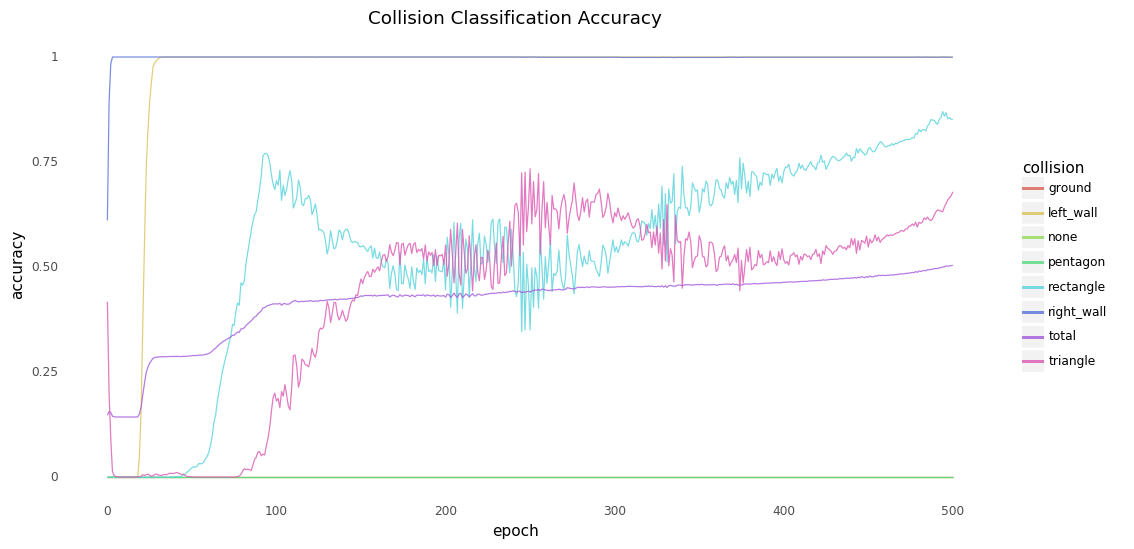

<ggplot: (-9223371850595710965)>

In [17]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_line(aes(x='epoch', y='accuracy', color='collision'), alpha = .8)
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)